# Train ML models

In [1]:
import pickle
import xarray as xr
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from functions import *

In [2]:
with open('./state.pkl', 'rb') as f:
    my_state = pickle.load(f)

In [3]:
input_vars = ['air_temperature', 'specific_humidity', 'eastward_wind', 'northward_wind', 
              'air_pressure']
output_vars = [
    'air_temperature_tendency_from_convection', 
    'specific_humidity_tendency_from_convection', 
    'eastward_wind_tendency_from_convection', 
    'northward_wind_tendency_from_convection',
    'convective_precipitation_rate'
]

## Load the prepared data and create train/valid split

In [4]:
!ls -t

inputs_nn.nc				 norm_arrs.pkl
outputs_nn.nc				 outputs_modified_entrainment.nc
3.0-Run-ML-models-online.ipynb		 inputs_modified_entrainment.nc
2.0-Train-ML-models.ipynb		 outputs_ref.nc
__pycache__				 inputs_ref.nc
functions.py				 nn_data.nc
1.0-Reference-simulations.ipynb		 outputs_norm.nc
1.1-Convert-data-for-ML.ipynb		 inputs_norm.nc
nn1.h5					 outputs_old.nc
stacked_outputs_modified_entrainment.nc  inputs_old.nc
stacked_inputs_modified_entrainment.nc	 ref_data.nc
stacked_outputs_ref.nc			 Climt.ipynb
stacked_inputs_ref.nc			 state.pkl
CliMT-ML.ipynb				 Climt-Copy1.ipynb


In [5]:
stacked_inputs = xr.open_dataarray(
    'stacked_inputs_ref.nc', chunks={'sample': 1000})
stacked_outputs = xr.open_dataarray(
    'stacked_outputs_ref.nc', chunks={'sample': 1000})

In [6]:
with open('norm_arrs.pkl', 'rb') as f:
    input_means, input_stds, output_means, output_stds = pickle.load(f)

In [7]:
ngeo = 32*64 # Samples per time step
stacked_inputs.shape

(2949120, 50)

In [8]:
split = (2_000_000 // ngeo) * ngeo; split

1998848

In [9]:
# Change of notation: X, Y are the inputs, outputs
X_train = stacked_inputs[:split].values
X_valid = stacked_inputs[split:].values
Y_train = stacked_outputs[:split].values
Y_valid = stacked_outputs[split:].values

I will not subtract the mean for the outputs, they should all be centered at zero (except precip which is just a diagnostic anyway). That way an inactive convection scheme will actually be zero.

In [10]:
X_train_norm = normalize(X_train, input_means, input_stds)
X_valid_norm = normalize(X_valid, input_means, input_stds)
Y_train_norm = normalize(Y_train, 0, output_stds)
Y_valid_norm = normalize(Y_valid, 0, output_stds)

## Train a neural network

### Build model

In [24]:
nn = keras.models.Sequential([
    Dense(128, input_shape=(50,), activation='elu'),
    Dense(128, activation='elu'),
    Dense(41)
])

In [25]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 41)                5289      
Total params: 28,329
Trainable params: 28,329
Non-trainable params: 0
_________________________________________________________________


In [26]:
nn.compile(keras.optimizers.Adam(lr=1e-4), 'mse')

### Train

In [29]:
nn.fit(X_train_norm, Y_train_norm, batch_size=1024, epochs=20, 
          validation_data=(X_valid_norm, Y_valid_norm))

Train on 1998848 samples, validate on 950272 samples
Epoch 1/20
1998848/1998848 [==============================] - 24s 12us/sample - loss: 0.3792 - val_loss: 0.2464
Epoch 2/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1974 - val_loss: 0.1791
Epoch 3/20
1998848/1998848 [==============================] - 23s 12us/sample - loss: 0.1648 - val_loss: 0.1615
Epoch 4/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1529 - val_loss: 0.1515
Epoch 5/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1457 - val_loss: 0.1461
Epoch 6/20
1998848/1998848 [==============================] - 23s 12us/sample - loss: 0.1408 - val_loss: 0.1418
Epoch 7/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1370 - val_loss: 0.1387
Epoch 8/20
1998848/1998848 [==============================] - 22s 11us/sample - loss: 0.1341 - val_loss: 0.1353
Epoch 9/20
1998848/1998848 [=======================

In [117]:
nn.save('./nn1.h5')

## Train a Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
rf = RandomForestRegressor(
    n_estimators=10,
    min_samples_leaf=100,
    n_jobs=4,
    verbose=100
)

In [ ]:
%%time
rf.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10


In [43]:
with open('rf1.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Offline evaluation

In [40]:
with open('rf1.pkl', 'rb') as f:
    rf = pickle.load(f)

In [13]:
nn = keras.models.load_model('./nn1.h5')

W0809 04:25:42.444643 140018281256320 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 04:25:42.447697 140018281256320 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0809 04:25:42.449457 140018281256320 deprecation.py:506] From /home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ze

In [14]:
def split_predictions(Y):
    outputs = {}
    ntime = Y.shape[0] // ngeo
    dims = ['time', 'lat', 'lon', 'mid_levels']
    for i, o in enumerate(output_vars):
        outputs[o] = xr.DataArray(
            Y[:, i*10:(i+1)*10].reshape((ntime, 32, 64, -1)),
            dims=dims
        ).squeeze()
    return xr.Dataset(outputs).transpose('time', 'mid_levels', 'lat', 'lon')

In [17]:
nn_preds = nn.predict(X_valid_norm, 10_000)
nn_preds.shape

(950272, 41)

In [18]:
nn_preds = split_predictions(unnormalize(nn_preds, 0, output_stds))

In [41]:
rf_preds = ...

In [19]:
truth = split_predictions(Y_valid)

In [20]:
nn_error = nn_preds - truth

### Plots

In [21]:
def plot_comparison(var, sl=None, mean=None, std=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    for ds, ax in zip([nn_preds, truth, nn_error], axs):
        if mean is not None: ds = ds.mean(mean)
        if std is not None: ds = ds.std(std)
        ds[var].isel(sl).plot(ax=ax)
    plt.tight_layout()

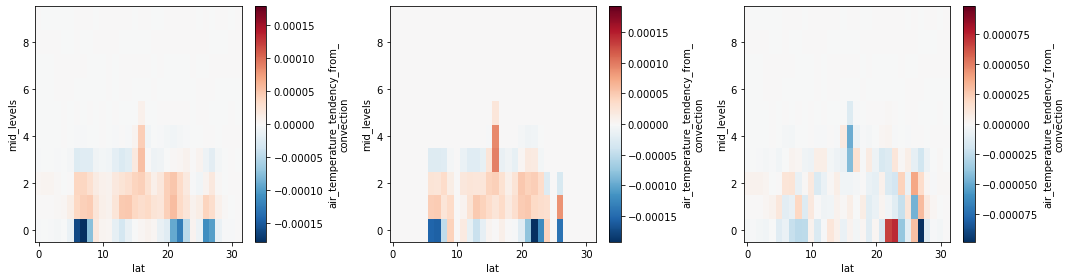

In [22]:
plot_comparison(
    'air_temperature_tendency_from_convection',
    {'time': -1, 'lon': 0}
)

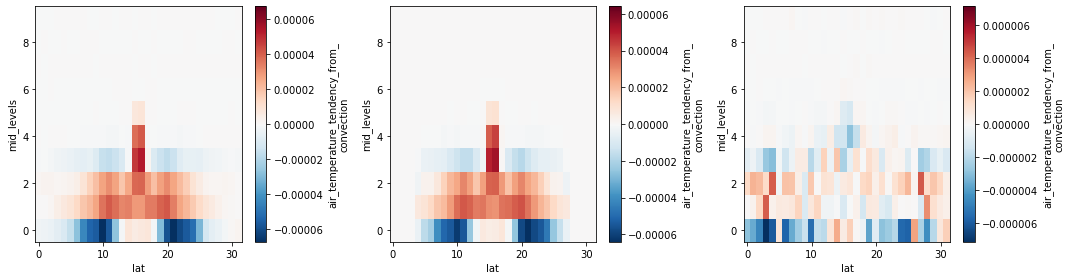

In [23]:
plot_comparison(
    'air_temperature_tendency_from_convection',
    mean=('time', 'lon')
)

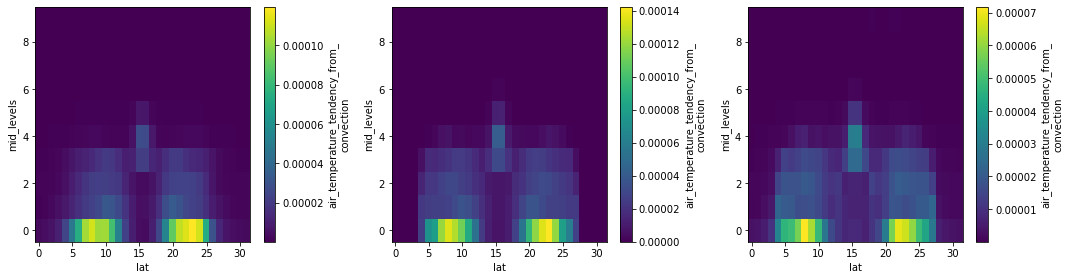

In [24]:
plot_comparison(
    'air_temperature_tendency_from_convection',
    std=('time', 'lon')
)

### Compute R2



In [26]:
tvar = ((truth - truth.mean(('time', 'lon')))**2).mean(('time', 'lon'))
sse = (nn_error**2).mean(('time', 'lon'))
r2 = 1-(sse/tvar)

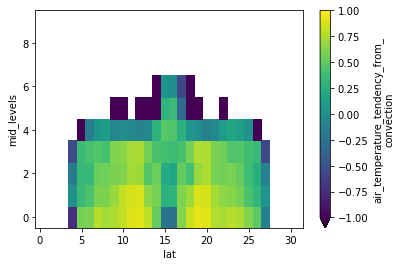

In [33]:
r2['air_temperature_tendency_from_convection'].plot(vmin=-1, vmax=1)

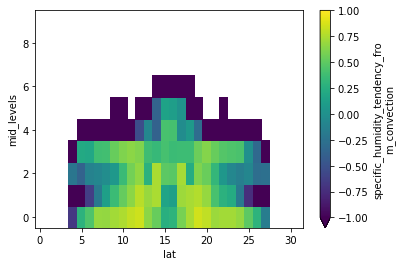

In [34]:
r2['specific_humidity_tendency_from_convection'].plot(vmin=-1, vmax=1)